Analyses properties of decorrelation and whitening methods for FC and Convolutional cases.

In [1]:
import numpy as np
import torch
from decorrelation.decorrelation import lower_triangular,Decorrelation, DecorConv2d # DecorrelationPatch2d # covariance, DecorrelationPatch2d, DecorrelationFC, lower_triangular
from decorrelation.plotting import *

# automatic reloading of modules when they change
%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def decorrelate(num_epochs, data, model, decor_lr):

    # covariance matrix before training
    X = model.decorrelate(data).view(data.shape[0],-1)
    A1 = (X.T @ X) / len(X)

    # train decorrelator
    L = np.zeros(num_epochs)
    for i in range(num_epochs):
        model.forward(data)
        L[i] = model.update()
        model.weight -= decor_lr * model.weight.grad
        print(f'iteration {i}\tloss: {L[i]:.3f}')

    # covariance matrix after training
    X = model.decorrelate(data).view(data.shape[0],-1)
    A2 = (X.T @ X) / len(X)

    return L, A1, A2

We start by showing effective decorrelation of correlated input

In [4]:
num_samples=1000
num_features=100
num_epochs=2000
seed=42
decor_lr=1e1
kappa=1e-1

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

# generate correlated data
d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.8 * torch.eye(num_features) + 0.2 * torch.ones((num_features, num_features)))
data = d.sample((num_samples,)).to(device)

# create a decorrelator
model = Decorrelation(in_features=num_features, bias=False, kappa=kappa).to(device)

L, A1, A2 = decorrelate(num_epochs, data, model, decor_lr)


iteration 0	loss: 0.059
iteration 1	loss: 0.051
iteration 2	loss: 0.046
iteration 3	loss: 0.042
iteration 4	loss: 0.038
iteration 5	loss: 0.036
iteration 6	loss: 0.033
iteration 7	loss: 0.032
iteration 8	loss: 0.030
iteration 9	loss: 0.029
iteration 10	loss: 0.028
iteration 11	loss: 0.027
iteration 12	loss: 0.026
iteration 13	loss: 0.025
iteration 14	loss: 0.024
iteration 15	loss: 0.024
iteration 16	loss: 0.023
iteration 17	loss: 0.023
iteration 18	loss: 0.022
iteration 19	loss: 0.022
iteration 20	loss: 0.022
iteration 21	loss: 0.021
iteration 22	loss: 0.021
iteration 23	loss: 0.021
iteration 24	loss: 0.021
iteration 25	loss: 0.020
iteration 26	loss: 0.020
iteration 27	loss: 0.020
iteration 28	loss: 0.020
iteration 29	loss: 0.020
iteration 30	loss: 0.019
iteration 31	loss: 0.019
iteration 32	loss: 0.019
iteration 33	loss: 0.019
iteration 34	loss: 0.019
iteration 35	loss: 0.019
iteration 36	loss: 0.019
iteration 37	loss: 0.019
iteration 38	loss: 0.019
iteration 39	loss: 0.018
iteration 

mean variance: 0.92


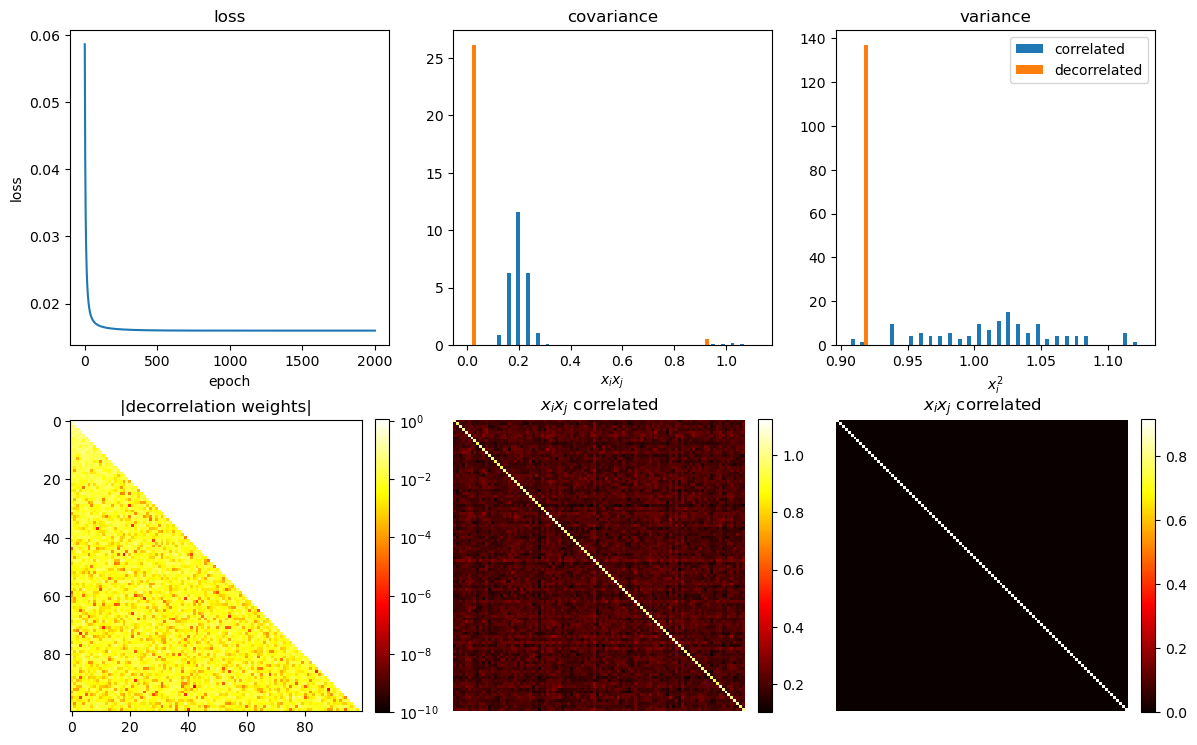

In [5]:
plot_decorrelation_results(model, L, A1, A2)
print(f'mean variance: {torch.mean(torch.diag(A2)):.2f}')

Decorrelation of correlated input using DecorConv2d

In [6]:
# generate [N, M] correlated input
num_examples=1000
in_channels=2
out_channels=3
height=10
width=10
kernel_size=(3,3)
num_samples=1000
num_epochs=1000
seed=42
decor_lr=1e-1
kappa=1e-1
downsample_perc=0.1

num_features=in_channels*height*width
size = in_channels * np.prod(kernel_size)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.1 * torch.eye(num_features) + 0.9 * torch.ones((num_features, num_features)))
data = d.sample((num_examples,)).reshape(num_examples,in_channels,height,width).to(device)

# create a convolutional decorrelator
# NOTE: how many samples for effective input decorrelation? Dependence on dim?
# nr of samples instead of perc?
# NOTE: version for immediate non-batched decorrelation...
model = DecorConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, bias=False, kappa=kappa, downsample_perc=downsample_perc).to(device)

L, A1, A2 = decorrelate(num_epochs, data, model, decor_lr) 


iteration 0	loss: 0.985
iteration 1	loss: 0.637
iteration 2	loss: 0.611
iteration 3	loss: 0.699
iteration 4	loss: 0.436
iteration 5	loss: 0.638
iteration 6	loss: 0.406
iteration 7	loss: 0.566
iteration 8	loss: 0.793
iteration 9	loss: 0.513
iteration 10	loss: 0.552
iteration 11	loss: 0.484
iteration 12	loss: 0.420
iteration 13	loss: 0.405
iteration 14	loss: 0.504
iteration 15	loss: 0.426
iteration 16	loss: 0.590
iteration 17	loss: 0.419
iteration 18	loss: 0.486
iteration 19	loss: 0.378
iteration 20	loss: 0.497
iteration 21	loss: 0.317
iteration 22	loss: 0.378
iteration 23	loss: 0.666
iteration 24	loss: 0.364
iteration 25	loss: 0.458
iteration 26	loss: 0.248
iteration 27	loss: 0.380
iteration 28	loss: 0.391
iteration 29	loss: 0.247
iteration 30	loss: 0.382
iteration 31	loss: 0.366
iteration 32	loss: 0.396
iteration 33	loss: 0.278
iteration 34	loss: 0.384
iteration 35	loss: 0.215
iteration 36	loss: 0.379
iteration 37	loss: 0.271
iteration 38	loss: 0.397
iteration 39	loss: 0.276
iteration 

mean variance: 0.57


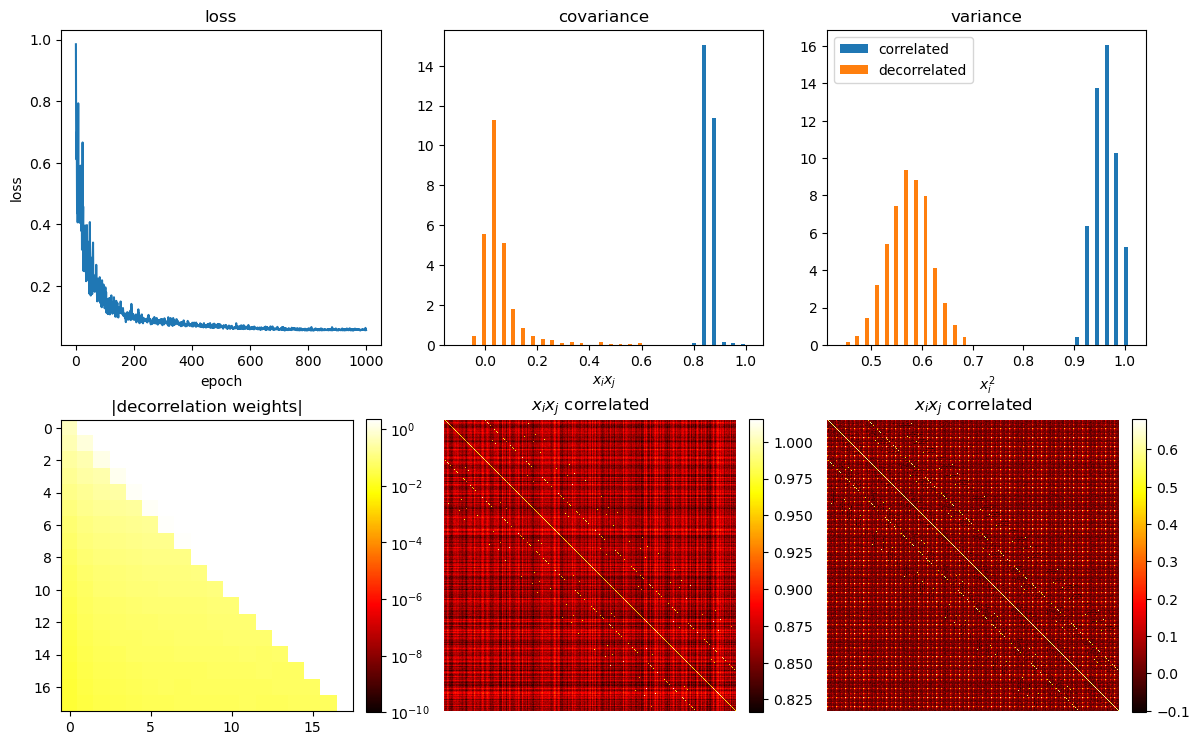

In [7]:
plot_decorrelation_results(model, L, A1, A2)
print(f'mean variance: {torch.mean(torch.diag(A2)):.2f}')